In [88]:
import xarray as xr
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
import string
from src import config_cesm
from src.models.diagnostics import roll_metric
from src.utils import util_cesm
REFERENCE_GRID = util_cesm.generate_sps_grid()

def add_hatching(ax, significance_mask, x_edges, y_edges, hatch='///', edgecolor='k'):
    Ny, Nx = significance_mask.shape

    for i in range(Ny):
        for j in range(Nx):
            if significance_mask[i, j]:
                rect = mpatches.Rectangle(
                    (x_edges[j], y_edges[i]),
                    x_edges[j+1] - x_edges[j],
                    y_edges[i+1] - y_edges[i],
                    hatch=hatch,
                    fill=False,
                    edgecolor=edgecolor,
                    linewidth=0
                )
                ax.add_patch(rect)

def plot_markers(ax, exceeds_persistence, x_centers, y_centers):
    for i in range(6):
        for j in range(12):
            if not exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], '.k', markersize=4) 

## Plot the ACC difference between finetuned and non-finetuned baselines

In [92]:
# input_config = "input2" # input2 = sic only, input4 = sic+all
acc_agg_dict = {}
acc_agg_ft_dict = {}
significance_ds_acc = {}
persistence_acc = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_input2_ensemble/diagnostics/acc_agg_persist.nc"))["acc"]

rmse_agg_dict = {}
rmse_agg_ft_dict = {}
significance_ds_rmse = {}
persistence_rmse = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_input2_ensemble/diagnostics/rmse_agg_persist.nc"))["rmse"]

for input_config in ["input2", "input4"]:
    acc_agg = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_{input_config}_ensemble/diagnostics/acc_agg.nc"))["acc"]
    acc_agg_dict[input_config] = acc_agg.sel(nn_member_id=np.arange(20)).mean("nn_member_id")

    acc_agg_ft = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_{input_config}_finetune/diagnostics/acc_agg.nc"))["acc"]
    acc_agg_ft_dict[input_config] = acc_agg_ft.sel(nn_member_id=np.arange(20)).mean("nn_member_id")

    significance_ds_acc[input_config] = xr.open_dataset(
        os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, f"confidence_intervals/obs_{input_config}_finetune_obs_{input_config}_ensemble_acc.nc")
    )

    rmse_agg = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_{input_config}_ensemble/diagnostics/rmse_agg.nc"))["rmse"]
    rmse_agg_dict[input_config] = rmse_agg.sel(nn_member_id=np.arange(20)).mean("nn_member_id")

    rmse_agg_ft = xr.open_dataset(os.path.join(config_cesm.PREDICTIONS_DIRECTORY, f"obs_{input_config}_finetune/diagnostics/rmse_agg.nc"))["rmse"]
    rmse_agg_ft_dict[input_config] = rmse_agg_ft.sel(nn_member_id=np.arange(20)).mean("nn_member_id")

    significance_ds_rmse[input_config] = xr.open_dataset(
        os.path.join(config_cesm.ANALYSIS_RESULTS_DIRECTORY, f"confidence_intervals/obs_{input_config}_finetune_obs_{input_config}_ensemble_rmse.nc")
    )

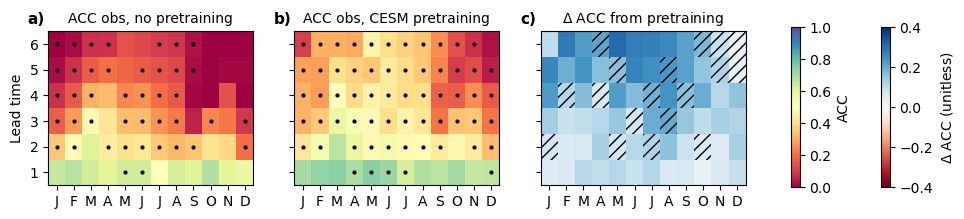

In [114]:
P_VALUE_CUTOFF = 0.01

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,2), sharey=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

ax = axs[0]
cax2 = ax.pcolormesh(x, y, acc_agg_dict["input2"], cmap='Spectral', shading='flat', vmin=0, vmax=1)
beats_persistence = acc_agg_dict["input2"] < persistence_acc.squeeze()
plot_markers(ax, beats_persistence, x_centers, y_centers)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(f"ACC obs, no pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
ax.set_ylabel("Lead time")

ax = axs[1]
ax.pcolormesh(x, y, acc_agg_ft_dict["input2"], cmap='Spectral', shading='flat', vmin=0, vmax=1)
beats_persistence = acc_agg_ft_dict["input2"] < persistence_acc.squeeze()
plot_markers(ax, beats_persistence, x_centers, y_centers)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(f"ACC obs, CESM pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

ax = axs[2]
cax = ax.pcolormesh(x, y, acc_agg_ft_dict["input2"] - acc_agg_dict["input2"], cmap='RdBu', shading='flat', vmin=-0.4, vmax=0.4)
significance_mask = (significance_ds_acc["input2"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(ax, significance_mask, x, y)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(rf"$\Delta$ ACC from pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
cbar_ax2 = fig.add_axes([1.05, 0.1, 0.01, 0.8])

plt.colorbar(cax, cax=cbar_ax2, label=r'$\Delta$ ACC (unitless)', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax, label=r'ACC', orientation='vertical')

panel_labels = list(string.ascii_lowercase)
for i, ax in enumerate(axs.flatten()):
    ax.annotate(
        f"{panel_labels[i]})",
        xy=(0, 1), xycoords="axes fraction",
        xytext=(-0.1, 1.03), textcoords="axes fraction",
        ha="left", va="bottom",
        fontsize=11, fontweight="bold"
    )

plt.show()


In [126]:
pred.start_prediction_month

<xarray.DataArray 'start_prediction_month' (start_prediction_month: 73)> Size: 584B
array(['2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
       '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
       '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
       '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
       '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-05-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000',
       '2017-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2017-11-01T00:00:00.000000000', '2017-12-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-05-01T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-07-01T00:00:00.000000000', '2020-08-01T00:00:00.000000000',
       '2020-09-01T00:00:00.000000000', '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000', '2021-04-01T00:00:00.000000000',
       '2021-05-01T00:00:00.000000000', '2021-06-01T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000', '2021-08-01T00:00:00.000000000',
       '2021-09-01T00:00:00.000000000', '2021-10-01T00:00:00.000000000',
       '2021-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-05-01T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-07-01T00:00:00.000000000', '2022-08-01T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000',
       '2023-01-01T00:00:00.000000000', '2023-02-01T00:00:00.000000000',
       '2023-03-01T00:00:00.000000000', '2023-04-01T00:00:00.000000000',
       '2023-05-01T00:00:00.000000000', '2023-06-01T00:00:00.000000000',
       '2023-07-01T00:00:00.000000000', '2023-08-01T00:00:00.000000000',
       '2023-09-01T00:00:00.000000000', '2023-10-01T00:00:00.000000000',
       '2023-11-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000',
       '2024-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * start_prediction_month  (start_prediction_month) datetime64[ns] 584B 2014...

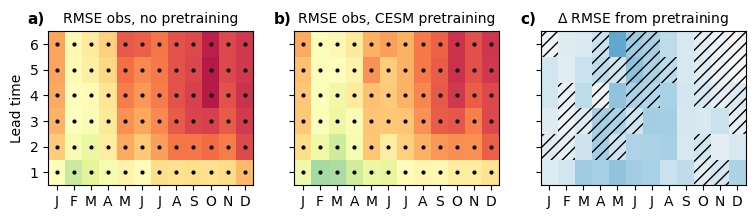

In [109]:
P_VALUE_CUTOFF = 0.01

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9,2), sharey=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

ax = axs[0]
ax.pcolormesh(x, y, rmse_agg_dict["input2"], cmap='Spectral_r', shading='flat', vmin=0.02, vmax=0.09)
beats_persistence = rmse_agg_dict["input2"] > persistence_rmse.squeeze()
plot_markers(ax, beats_persistence, x_centers, y_centers)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(f"RMSE obs, no pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
ax.set_ylabel("Lead time")

ax = axs[1]
ax.pcolormesh(x, y, rmse_agg_ft_dict["input2"], cmap='Spectral_r', shading='flat', vmin=0.02, vmax=0.09)
beats_persistence = rmse_agg_ft_dict["input2"] > persistence_rmse.squeeze()
plot_markers(ax, beats_persistence, x_centers, y_centers)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_title(f"RMSE obs, CESM pretraining", fontsize=10)
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

ax = axs[2]
ax.pcolormesh(x, y, rmse_agg_ft_dict["input2"] - rmse_agg_dict["input2"], cmap='RdBu_r', shading='flat', vmin=-0.02, vmax=0.02)
significance_mask = (significance_ds_rmse["input2"].p_value > P_VALUE_CUTOFF).astype(int)
add_hatching(ax, significance_mask, x, y)
ax.set_yticks(y_centers, labels=np.arange(1,7,1))
ax.set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
ax.set_title(rf"$\Delta$ RMSE from pretraining", fontsize=10)

panel_labels = list(string.ascii_lowercase)
for i, ax in enumerate(axs.flatten()):
    ax.annotate(
        f"{panel_labels[i]})",
        xy=(0, 1), xycoords="axes fraction",
        xytext=(-0.1, 1.03), textcoords="axes fraction",
        ha="left", va="bottom",
        fontsize=11, fontweight="bold"
    )

plt.show()


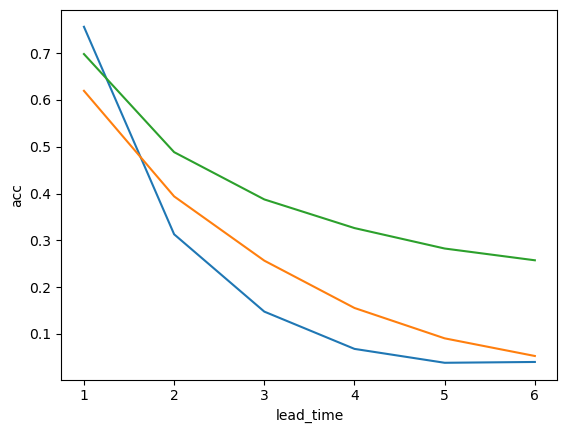

In [121]:
persistence_acc.mean("month").plot()
acc_agg_dict["input2"].mean("month").plot()
acc_agg_ft_dict["input2"].mean("month").plot()

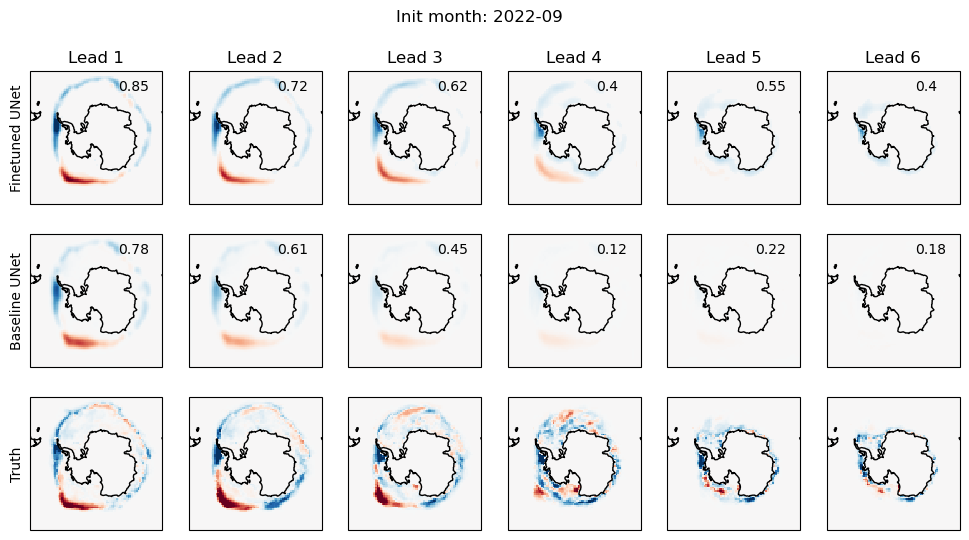

In [73]:
pred = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/UNetRes3_best_predictions.nc")["predictions"]
pred_ft = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_finetune/UNetRes3_best_predictions.nc")["predictions"]
targets = xr.open_dataset("/scratch/users/yucli/cesm_data_processed/data_pairs/seaice_plus_auxiliary_obs/targets_member_obs.nc")["data"]
persist = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/baselines/persistence_predictions.nc")["predictions"]

def plot_pred_example(da_pred1, da_pred2, da_truth, start_prediction_month, savepath=None):
    import cartopy.crs as ccrs
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    lon = REFERENCE_GRID.lon.data
    lat = REFERENCE_GRID.lat.data

    fig, axs = plt.subplots(figsize=(12, 6), nrows=3, ncols=6, sharex=True, sharey=True, 
                            subplot_kw={'projection': ccrs.SouthPolarStereo()})
    start_pred_mon = da_truth.start_prediction_month.sel(start_prediction_month=start_prediction_month)

    for i in range(6):
        pred1 = da_pred1.sel(start_prediction_month=start_prediction_month).isel(lead_time=i).squeeze()
        pred2 = da_pred2.sel(start_prediction_month=start_prediction_month).isel(lead_time=i).squeeze()
        truth = da_truth.sel(start_prediction_month=start_prediction_month).isel(lead_time=i).squeeze()

        axs[0,i].pcolormesh(lon, lat, pred1, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="RdBu_r")
        axs[1,i].pcolormesh(lon, lat, pred2, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="RdBu_r")
        axs[2,i].pcolormesh(lon, lat, truth, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="RdBu_r")

        # print acc 
        acc_1 =  np.corrcoef(pred1.to_numpy().flatten(), truth.to_numpy().flatten()).round(2)[0,1]
        acc_2 =  np.corrcoef(pred2.to_numpy().flatten(), truth.to_numpy().flatten()).round(2)[0,1]
        axs[0,i].text(25, -60, acc_1, transform=ccrs.PlateCarree())
        axs[1,i].text(25, -60, acc_2, transform=ccrs.PlateCarree())
        axs[0,i].set_title(f"Lead {i+1}")
        for j in range(3):
            axs[j,i].coastlines()
            axs[j,0].yaxis.set_visible(True) 
            axs[j,0].set_yticks([])
    axs[0,0].set_ylabel("Finetuned UNet")
    axs[1,0].set_ylabel("Baseline UNet")
    axs[2,0].set_ylabel("Truth")

    plt.suptitle(f"Init month: {start_pred_mon.values.astype('datetime64[M]')}")
    if savepath is not None:
        plt.savefig(savepath, dpi=250, bbox_inches='tight')
    plt.show()


plot_pred_example(pred_ft.mean("nn_member_id"), pred.mean("nn_member_id"), targets, np.datetime64("2022-09-01"))


In [11]:
pred

<xarray.DataArray 'predictions' (start_prediction_month: 73, member_id: 1,
                                 nn_member_id: 20, lead_time: 6, y: 80, x: 80)> Size: 224MB
[56064000 values with dtype=float32]
Coordinates:
  * start_prediction_month  (start_prediction_month) datetime64[ns] 584B 2014...
  * member_id               (member_id) <U3 12B 'obs'
  * nn_member_id            (nn_member_id) int64 160B 0 1 2 3 4 ... 16 17 18 19
  * lead_time               (lead_time) int64 48B 1 2 3 4 5 6
  * y                       (y) float64 640B -4.208e+06 -4.101e+06 ... 4.208e+06
  * x                       (x) float64 640B -4.208e+06 -4.101e+06 ... 4.208e+06

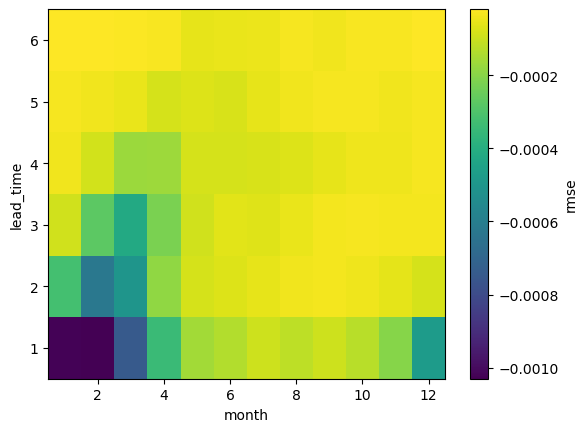

In [15]:
rmse_agg = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg.nc")["rmse"]
rmse_agg_old = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg_old.nc")["rmse"]

(rmse_agg - rmse_agg_old).sel(nn_member_id=np.arange(20)).mean("nn_member_id").plot()

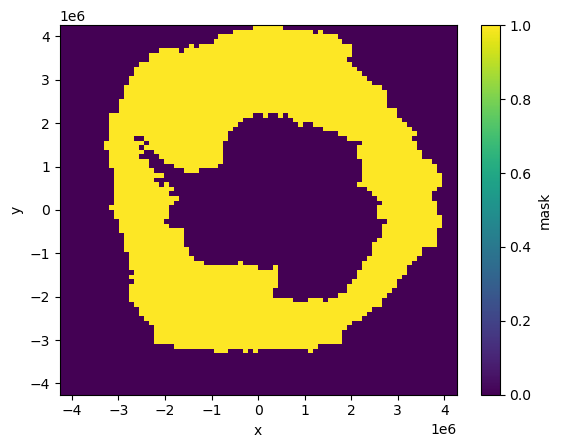

In [10]:
xr.open_dataset("/oak/stanford/groups/earlew/yuchen/obs_data/ice_occurrence_mask.nc")["mask"].plot()

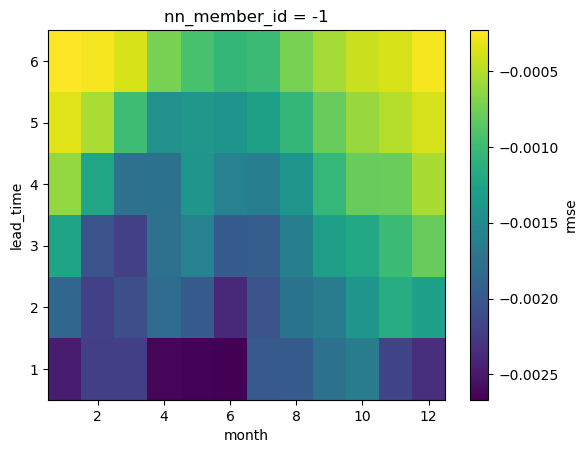

In [29]:
rmse_agg = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg.nc")["rmse"]

(rmse_agg.sel(nn_member_id=-1) - rmse_agg.sel(nn_member_id=np.arange(20)).mean("nn_member_id")).plot()